In [2]:
import os
from tempfile import tempdir
from termios import TOSTOP
from time import time
from turtle import color
from unittest.mock import NonCallableMagicMock
import pandas as pd
import numpy as np
import warnings
import math
import re

import seaborn as sns
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import tqdm
import importlib

import matplotlib.pyplot as plt
# from PySide2.QtWidgets import QFileDialog, QApplication
# from PySide2.QtCore import Qt
from copy import copy 


In [3]:

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.encapsulation.constant import Atoms
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

import importlib
import corems.lc_icpms_ftms.calc.lc_icrms_qc_assign as icrms

importlib.reload(icrms)


<module 'corems.lc_icpms_ftms.calc.lc_icrms_qc_assign' from '/Users/christiandewey/CoreMS/corems/lc_icpms_ftms/calc/lc_icrms_qc_assign.py'>

In [36]:

def getParser(file):
    parser = rawFileReader.ImportMassSpectraThermoMSFileReader(file)
    return parser

def assign_formula(parser, interval, timerange, refmasslist=None):
    #Function to build formula assignment lists
    #Retrieve TIC for MS1 scans over the time range between 'timestart' and 'timestop' 

    tic=parser.get_tic(ms_type='MS')[0]
    tic_df=pd.DataFrame({'time': tic.time,'scan': tic.scans})

    times=list(range(timerange[0],timerange[1],interval))

    results=[]
    
    for timestart in times:

        scans=tic_df[tic_df.time.between(timestart,timestart+interval)].scan.tolist()

        mass_spectrum = parser.get_average_mass_spectrum_by_scanlist(scans)    
        mass_spectrum.molecular_search_settings.ion_charge = 1

        ppp = mass_spectrum.polarity
        print('polarity: %s' %ppp)
        #mass_spectrum.mass_spectrum.settings.calib_sn_threshold
        #mass_spectrum.mass_spectrum.settings.calib_pol_order
        #mass_spectrum.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)
        #MzDomainCalibration(mass_spectrum, ref_file_location).run()

        if refmasslist:
            mass_spectrum.settings.min_calib_ppm_error = 10
            mass_spectrum.settings.max_calib_ppm_error = -10
            calfn = MzDomainCalibration(mass_spectrum, refmasslist)
            ref_mass_list_fmt = calfn.load_ref_mass_list(refmasslist)

            imzmeas, mzrefs = calfn.find_calibration_points(mass_spectrum, ref_mass_list_fmt,
                                                        calib_ppm_error_threshold=(0, 2.0),
                                                        calib_snr_threshold=3)

            calfn.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)


        SearchMolecularFormulas(mass_spectrum, first_hit=False).run_worker_mass_spectrum()

        mass_spectrum.percentile_assigned(report_error=True)

        assignments=mass_spectrum.to_dataframe()

        assignments['Time']=timestart

        results.append(assignments)
    
    results=pd.concat(results,ignore_index=True)

    return(results)    

def plot_ms(df1, start_mz, end_mz, tstart, df2=None,df3=None, assignment= None, ax_ms=None, lbls=None, norm=False, labs=False, colors=None):   
    if ax_ms == None:
        f, ax = plt.subplots()
    
    else:
        ax = ax_ms

    if colors is not None:
        cols = colors
    else:
        cols = ['C0', 'C1', 'C2']
    mzrange= end_mz - start_mz
    ms_t_int=df1[df1['Time'] == tstart]
    ms_df = ms_t_int[((ms_t_int['Calibrated m/z']-start_mz)<mzrange) & ((ms_t_int['Calibrated m/z']-start_mz)>0)]

    maxdf1 = max(ms_df['S/N'])

    if norm:
        ms_df['S/N Norm'] = ms_df['S/N'] / maxdf1
    else:
        ms_df['S/N Norm'] = ms_df['S/N'] 

    

    print(ms_df['S/N Norm'])

    if lbls is not None:
        labels = lbls
    else:
        lbls = [None, None, None]

 
    _, stemlines1, _ =ax.stem('Calibrated m/z','S/N Norm',data=ms_df,  markerfmt=' ', basefmt=' ', linefmt=cols[0], label = labels[0])
    
    if df2 is not None:
        ms_t_int2=df2[df2['Time'] == tstart]
        ms_df2 = ms_t_int2[(abs(ms_t_int2['Calibrated m/z']-start_mz)<mzrange)& ((ms_t_int2['Calibrated m/z']-start_mz)>0)]

        maxdf2 = max(ms_df2['S/N'])

        if norm:
            ms_df2['S/N Norm'] = ms_df2['S/N'] / maxdf2
        else:
            ms_df2['S/N Norm'] = ms_df2['S/N'] 
        
        _, stemlines2, _ =ax.stem('Calibrated m/z','S/N Norm',data=ms_df2,  markerfmt=' ', basefmt=' ', linefmt=cols[1], label = labels[1])

    if df3 is not None:
        ms_t_int3=df3[df3['Time'] == tstart]
        ms_df3 = ms_t_int3[(abs(ms_t_int3['Calibrated m/z']-start_mz)<mzrange)& ((ms_t_int3['Calibrated m/z']-start_mz)>0)]

        maxdf3 = max(ms_df3['S/N'])

        if norm:
            ms_df3['S/N Norm'] = ms_df3['S/N'] / maxdf3
        else:
            ms_df3['S/N Norm'] = ms_df3['S/N'] 
        
        _, stemlines3, _ =ax.stem('Calibrated m/z','S/N Norm',data=ms_df3,  markerfmt=' ', basefmt=' ', linefmt=cols[2], label = labels[2])
    
    if df3 is not None:
        ax.set_ylim(0, max([maxdf1, maxdf2, maxdf3]) * 1.1)
    elif df2 is not None:
        ax.set_ylim(0, max([maxdf1, maxdf2]) * 1.1)
    else: 
        ax.set_ylim(0, maxdf1 * 1.1)

    ax.set_xlim(left = start_mz - mzrange*0.1, right = start_mz + mzrange + mzrange*0.1) 

    if labs:
        for mzr,peakr,mf,er in zip(ms_df['Calibrated m/z'], ms_df['S/N Norm'], ms_df['Molecular Formula'],  ms_df['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

            mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
            ax.text(mzr, peakr + 0.02 *max(ms_df['S/N Norm']), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color=cols[0])

        if df2 is not None:

            for mzr,peakr,mf, er in zip(ms_df2['Calibrated m/z'], ms_df2['S/N Norm'], ms_df2['Molecular Formula'], ms_df2['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

                mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
                ax.text(mzr, peakr + 0.02 *max(ms_df2['S/N Norm']), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color = cols[1])

        if df3 is not None:

            for mzr,peakr,mf, er in zip(ms_df3['Calibrated m/z'], ms_df3['S/N Norm'], ms_df3['Molecular Formula'], ms_df3['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

                mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
                ax.text(mzr, peakr + 0.02 *max(ms_df3['S/N Norm']), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color = cols[2])

   # theor_mz=pattern.mdiff+result['mass']
   # theor_int=pattern.ratio*result['abundance']
   # ax.stem(theor_mz,theor_int, basefmt=' ',linefmt='gray')

   # for isotope in pattern.isotope[pattern.requirement=='Y']:
   #     ax.stem('mz','intense',data=result[isotope],  markerfmt=' ', basefmt=' ',linefmt='red')
    if ax == None:

        ax.legend(('other', 'target'),bbox_to_anchor=(1.05, 1.0), loc='upper left',frameon=False)

        if(assignment):

            mf = assignment[0]
            score = assignment[1]
            er = assignment[2]

            ax.text(1.05,0.7,mf,transform=ax.transAxes)
            ax.text(1.05,0.6,'Error (ppm) = %.3f ' %er ,transform=ax.transAxes)
            ax.text(1.05,0.5,'Score = %.3f' %score ,transform=ax.transAxes)

    if norm: 
        ax.set(xlabel='Calibrated m/z',ylabel='Normalized S/N')
    else: 
        ax.set(xlabel='Calibrated m/z',ylabel='S/N')
    #ax.set_title('%.2f' %timerange[0] + ' to %.2f' %timerange[1] +' min', fontsize = 'medium')
    ax.legend(bbox_to_anchor = (1.00, 0.5), frameon =False, loc = 'center left')
    ax.axhline(y=0.0, color='black')
    plt.setp(stemlines1,'color', cols[0], 'linewidth', 2)
    if df2 is not None:
        plt.setp(stemlines2, 'color', cols[1],'linewidth', 2)
    if df3 is not None:
        plt.setp(stemlines3, 'color', cols[2],'linewidth', 2)
    plt.tight_layout()
    if ax_ms == None:
        return ax


def filterMzRange(results, mz_range):

    mz_i = mz_range[0]
    mz_f = mz_range[1]

    sub = results[(results['m/z'] >= mz_i) & (results['m/z'] <= mz_f)]

    return sub


def pltMZerror(results, bins=50):
    ## assignment error distribution
    _, ax = plt.subplots()
    for mol_class in sorted(results['mol_class'].unique()):

        counts, bins = np.histogram(np.asarray(results[results['mol_class']==mol_class]['m/z Error (ppm)']),bins = bins)

        ax.plot(bins[:-1], counts, label = mol_class)

    ax.set_xlim(-0.5,0.5)
    ax.legend(frameon=False)
    ax.set_xlabel('m/z assignment error (ppm)')
    ax.set_ylabel('# assigned features')

    return ax

def pltMZerror_pts(results):
    ## assignment error distribution
    _, ax = plt.subplots()
    for mol_class in sorted(results['mol_class'].unique()):

        ax.scatter(results[results['mol_class']==mol_class]['Calibrated m/z'], results[results['mol_class']==mol_class]['m/z Error (ppm)'], label = mol_class)

    #ax.set_xlim(-0.5,0.5)
    ax.legend(frameon=False,bbox_to_anchor=(1.0, 0.5))
    ax.set_xlabel('calibrated m/z')
    ax.set_ylabel('assignment error (ppm)')

    return ax

def assignMolClass(resultsdf, mz_cutoff = 800, sn_lim = 3):

    filtered_results=resultsdf[(resultsdf['m/z']<mz_cutoff) & (resultsdf['S/N']>sn_lim)]

    filtered_results['N']=filtered_results['N'].fillna(0)
    filtered_results['O']=filtered_results['O'].fillna(0)
    #filtered_results['S']=filtered_results['S'].fillna(0)
    #filtered_results['P']=filtered_results['Fe'].fillna(0)
    filtered_results['Cu']=filtered_results['Cu'].fillna(0)

    filtered_results['mol_class']='Unassigned'
    filtered_results['mol_class'][filtered_results['C']>0]='CHO'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['N']>0.5)]='CHON'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['S']>0.5)]='CHOS'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Fe']>0.5)]='CHOFe'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5)]='CHOCu'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5) & (filtered_results['N']>0.5)]='CHONCu'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5) & (filtered_results['S']>0.5)]='CHOSCu'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Na']>0.5) & (filtered_results['N']>0.5)]='CHONNa'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['P']>0.5) & (filtered_results['Na']>0.5) & (filtered_results['N']>0.5)]='CHONPNa'


    results= filtered_results[filtered_results['mol_class'] != 'Unassigned'] #[filtered_results['Is Isotopologue']==0]
    results['N/C']=results['O']/results['C']
    results['H/C']=results['H']/results['C']
    results['N/C']=results['N']/results['C']

    return results


In [33]:
# 1: assign formula to full scan 
MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 2
MSParameters.ms_peak.peak_min_prominence_percent = 0.001

MSParameters.molecular_search.error_method = 'None'
MSParameters.molecular_search.min_ppm_error = -0.3
MSParameters.molecular_search.max_ppm_error = 0.3

MSParameters.molecular_search.isProtonated = True
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

MSParameters.molecular_search.score_method = "prob_score"
MSParameters.molecular_search.output_score_method = "prob_score"


MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = -1
MSParameters.molecular_search.max_dbe = 20

MSParameters.molecular_search.usedAtoms['C'] = (1,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,6)
MSParameters.molecular_search.usedAtoms['Cu'] = (0,1)
MSParameters.molecular_search.usedAtoms['S'] = (0,1)


In [34]:

data2='/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/21T at NHMFL/2022-10 Nicole & Christian/Christian/spring/20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw'
data1='/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/21T at NHMFL/2022-10 Nicole & Christian/Christian/spring/20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw'
qh2o='/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/21T at NHMFL/2022-10 Nicole & Christian/Christian/spring/20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw'


refmasslist = '/Users/christiandewey/CoreMS/tests/tests_data/ftms/nom_pos.ref'

savedir = '/Users/christiandewey/Desktop/221107-CoreMS'

trange = [4,28]
interval = 2
parser1 = getParser(data1)  #fullmz
results1 = assign_formula(parser1,interval=interval,timerange=trange, refmasslist=refmasslist)



polarity: 1
MS Obj loaded - 1634 peaks found.
MS Obj loaded - 1634 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.


100%|██████████| 220/220 [00:00<00:00, 922.12it/s]


Started database insert using 5784 iterations for a total of 289174 rows


5784it [00:08, 710.01it/s]


'runworker'  16389.00 ms


Loading molecular formula database: 199394it [00:07, 27688.32it/s]
Started molecular formula search for class {"N": 1, "O": 18, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 121.67it/s]        
Loading molecular formula database: 200865it [00:08, 23578.72it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 150.82it/s]
Loading molecular formula database: 204150it [00:08, 24448.05it/s]
Started molecular formula search for class {"N": 5, "O": 13, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 149.18it/s]        
Loading molecular formula database: 159570it [00:05, 27022.08it/s]
Started molecular formula search for class {"N": 6, "S": 1, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 220/220 [00:01<00:00, 173.04it/s]


'run_molecular_formula'  54357.66 ms
1235 assigned peaks and 399 unassigned peaks, total  = 75.58 %, relative abundance = 82.42 %, RMS error (best candidate) (ppm) = 0.122
polarity: 1
MS Obj loaded - 2758 peaks found.
MS Obj loaded - 2758 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
66 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 1235 fn evals and 18 iterations
'runworker'  5103.53 ms


Loading molecular formula database: 199394it [00:08, 23650.91it/s]
Started molecular formula search for class {"N": 1, "O": 18, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 69.54it/s]        
Loading molecular formula database: 200865it [00:09, 21651.55it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 91.39it/s] 
Loading molecular formula database: 204150it [00:08, 23115.42it/s]
Started molecular formula search for class {"N": 5, "O": 13, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 63.58it/s]        
Loading molecular formula database: 159570it [00:06, 23131.37it/s]
Started molecular formula search for class {"N": 6, "S": 1, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 220/220 [00:02<00:00, 105.60it/s]


'run_molecular_formula'  53269.94 ms
2402 assigned peaks and 356 unassigned peaks, total  = 87.09 %, relative abundance = 93.56 %, RMS error (best candidate) (ppm) = 0.122
polarity: 1
MS Obj loaded - 3769 peaks found.
MS Obj loaded - 3769 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
133 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.015 ppm
minimize function performed 330 fn evals and 6 iterations
'runworker'  5146.11 ms


Loading molecular formula database: 199394it [00:08, 22463.70it/s]
Started molecular formula search for class {"N": 1, "O": 18, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:14<00:00, 21.35it/s]        
Loading molecular formula database: 200865it [00:10, 19062.12it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:10<00:00, 29.89it/s]
Loading molecular formula database: 204150it [00:10, 20193.47it/s]
Started molecular formula search for class {"N": 5, "O": 13, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:12<00:00, 23.61it/s]        
Loading molecular formula database: 159570it [00:08, 19272.78it/s]
Started molecular formula search for class {"N": 6, "S": 1, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 220/220 [00:07<00:00, 28.12it/s]


'run_molecular_formula'  87951.70 ms
3231 assigned peaks and 538 unassigned peaks, total  = 85.73 %, relative abundance = 91.59 %, RMS error (best candidate) (ppm) = 0.121
polarity: 1
MS Obj loaded - 4003 peaks found.
MS Obj loaded - 4003 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
182 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.023 ppm
minimize function performed 322 fn evals and 6 iterations
'runworker'  5102.60 ms


Loading molecular formula database: 199394it [00:09, 21593.36it/s]
Started molecular formula search for class {"N": 1, "O": 18, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:07<00:00, 38.28it/s]        
Loading molecular formula database: 200865it [00:09, 20486.78it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:06<00:00, 49.10it/s]
Loading molecular formula database: 204150it [00:10, 19859.41it/s]
Started molecular formula search for class {"N": 5, "O": 13, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:08<00:00, 34.78it/s]        
Loading molecular formula database: 159570it [00:07, 20722.81it/s]
Started molecular formula search for class {"N": 6, "S": 1, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 220/220 [00:03<00:00, 58.92it/s]


'run_molecular_formula'  68862.52 ms
3525 assigned peaks and 478 unassigned peaks, total  = 88.06 %, relative abundance = 94.73 %, RMS error (best candidate) (ppm) = 0.109
polarity: 1
MS Obj loaded - 4329 peaks found.
MS Obj loaded - 4329 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
211 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 327 fn evals and 6 iterations
'runworker'  5369.72 ms


Loading molecular formula database: 199394it [00:09, 21653.39it/s]
Started molecular formula search for class {"N": 1, "O": 18, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:07<00:00, 40.74it/s]        
Loading molecular formula database: 200865it [00:10, 19731.59it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:05<00:00, 57.98it/s]
Loading molecular formula database: 204150it [00:10, 18917.13it/s]
Started molecular formula search for class {"N": 5, "O": 13, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:07<00:00, 38.63it/s]        
Loading molecular formula database: 159570it [00:07, 20027.70it/s]
Started molecular formula search for class {"N": 6, "S": 1, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 220/220 [00:04<00:00, 53.16it/s]


'run_molecular_formula'  68405.41 ms
3873 assigned peaks and 456 unassigned peaks, total  = 89.47 %, relative abundance = 95.41 %, RMS error (best candidate) (ppm) = 0.107
polarity: 1
MS Obj loaded - 4619 peaks found.
MS Obj loaded - 4619 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
241 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 324 fn evals and 6 iterations
'runworker'  5270.38 ms


Loading molecular formula database: 199394it [00:09, 21908.84it/s]
Started molecular formula search for class {"N": 1, "O": 18, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:07<00:00, 37.67it/s]        
Loading molecular formula database: 200865it [00:10, 18440.12it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:05<00:00, 53.69it/s]
Loading molecular formula database: 204150it [00:09, 21041.52it/s]
Started molecular formula search for class {"N": 5, "O": 13, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:07<00:00, 42.63it/s]        
Loading molecular formula database: 159570it [00:08, 19459.43it/s]
Started molecular formula search for class {"N": 6, "S": 1, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 220/220 [00:04<00:00, 54.94it/s]


'run_molecular_formula'  68239.62 ms
4157 assigned peaks and 462 unassigned peaks, total  = 90.00 %, relative abundance = 96.29 %, RMS error (best candidate) (ppm) = 0.102
polarity: 1
MS Obj loaded - 4899 peaks found.
MS Obj loaded - 4899 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
254 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.016 ppm
minimize function performed 324 fn evals and 6 iterations
'runworker'  5470.21 ms


Loading molecular formula database: 199394it [00:09, 20360.93it/s]
Started molecular formula search for class {"N": 1, "O": 18, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:08<00:00, 36.53it/s]        
Loading molecular formula database: 200865it [00:10, 19499.48it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:06<00:00, 48.84it/s]
Loading molecular formula database: 204150it [00:11, 18094.71it/s]
Started molecular formula search for class {"N": 5, "O": 13, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:06<00:00, 43.35it/s]        
Loading molecular formula database: 159570it [00:07, 20448.57it/s]
Started molecular formula search for class {"N": 6, "S": 1, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 220/220 [00:05<00:00, 41.55it/s]


'run_molecular_formula'  71666.59 ms
4349 assigned peaks and 550 unassigned peaks, total  = 88.77 %, relative abundance = 96.06 %, RMS error (best candidate) (ppm) = 0.104
polarity: 1
MS Obj loaded - 5289 peaks found.
MS Obj loaded - 5289 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
268 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.023 ppm
minimize function performed 470 fn evals and 10 iterations
'runworker'  5234.58 ms


Loading molecular formula database: 199394it [00:09, 21314.75it/s]
Started molecular formula search for class {"N": 1, "O": 18, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:10<00:00, 29.34it/s]        
Loading molecular formula database: 200865it [00:11, 18203.08it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:08<00:00, 36.76it/s]
Loading molecular formula database: 204150it [00:10, 19472.96it/s]
Started molecular formula search for class {"N": 5, "O": 13, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:07<00:00, 40.98it/s]        
Loading molecular formula database: 159570it [00:08, 19046.55it/s]
Started molecular formula search for class {"N": 6, "S": 1, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 220/220 [00:05<00:00, 40.58it/s]


'run_molecular_formula'  76102.50 ms
4587 assigned peaks and 702 unassigned peaks, total  = 86.73 %, relative abundance = 95.06 %, RMS error (best candidate) (ppm) = 0.105
polarity: 1
MS Obj loaded - 5527 peaks found.
MS Obj loaded - 5527 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
262 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.016 ppm
minimize function performed 3029 fn evals and 71 iterations
'runworker'  5208.16 ms


Loading molecular formula database: 199394it [00:09, 20810.32it/s]
Started molecular formula search for class {"N": 1, "O": 18, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:12<00:00, 23.53it/s]        
Loading molecular formula database: 200865it [00:11, 18178.38it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:10<00:00, 27.29it/s]
Loading molecular formula database: 204150it [00:11, 18474.96it/s]
Started molecular formula search for class {"N": 5, "O": 13, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:14<00:00, 21.29it/s]        
Loading molecular formula database: 159570it [00:09, 17399.02it/s]
Started molecular formula search for class {"N": 6, "S": 1, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 220/220 [00:07<00:00, 27.78it/s]


'run_molecular_formula'  92297.52 ms
4758 assigned peaks and 769 unassigned peaks, total  = 86.09 %, relative abundance = 93.47 %, RMS error (best candidate) (ppm) = 0.098
polarity: 1
MS Obj loaded - 4048 peaks found.
MS Obj loaded - 4048 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
230 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.017 ppm
minimize function performed 503 fn evals and 10 iterations
'runworker'  5796.19 ms


Loading molecular formula database: 199394it [00:08, 22760.07it/s]
Started molecular formula search for class {"N": 1, "O": 18, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:07<00:00, 40.53it/s]        
Loading molecular formula database: 200865it [00:09, 20441.27it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:05<00:00, 52.81it/s]
Loading molecular formula database: 204150it [00:10, 18615.64it/s]
Started molecular formula search for class {"N": 5, "O": 13, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:05<00:00, 58.08it/s]        
Loading molecular formula database: 159570it [00:06, 22847.13it/s]
Started molecular formula search for class {"N": 6, "S": 1, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 220/220 [00:04<00:00, 48.56it/s]


'run_molecular_formula'  65509.39 ms
3589 assigned peaks and 459 unassigned peaks, total  = 88.66 %, relative abundance = 93.07 %, RMS error (best candidate) (ppm) = 0.088
polarity: 1
MS Obj loaded - 3321 peaks found.
MS Obj loaded - 3321 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
211 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.017 ppm
minimize function performed 331 fn evals and 6 iterations
'runworker'  5836.39 ms


Loading molecular formula database: 199394it [00:08, 23402.14it/s]
Started molecular formula search for class {"N": 1, "O": 18, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:05<00:00, 51.37it/s]        
Loading molecular formula database: 200865it [00:09, 20845.77it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 62.23it/s]
Loading molecular formula database: 204150it [00:09, 21287.35it/s]
Started molecular formula search for class {"N": 5, "O": 13, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:05<00:00, 54.97it/s]        
Loading molecular formula database: 159570it [00:07, 20068.89it/s]
Started molecular formula search for class {"N": 6, "S": 1, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 220/220 [00:04<00:00, 45.28it/s]


'run_molecular_formula'  62892.88 ms
2839 assigned peaks and 482 unassigned peaks, total  = 85.49 %, relative abundance = 90.32 %, RMS error (best candidate) (ppm) = 0.080
polarity: 1
MS Obj loaded - 3403 peaks found.
MS Obj loaded - 3403 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
185 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.011 ppm
minimize function performed 336 fn evals and 6 iterations
'runworker'  5496.48 ms


Loading molecular formula database: 199394it [00:08, 22312.58it/s]
Started molecular formula search for class {"N": 1, "O": 18, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:06<00:00, 47.77it/s]        
Loading molecular formula database: 200865it [00:10, 20066.41it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:06<00:00, 49.31it/s]
Loading molecular formula database: 204150it [00:10, 20143.84it/s]
Started molecular formula search for class {"N": 5, "O": 13, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:06<00:00, 47.14it/s]        
Loading molecular formula database: 159570it [00:07, 21331.05it/s]
Started molecular formula search for class {"N": 6, "S": 1, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 220/220 [00:07<00:00, 29.77it/s]


'run_molecular_formula'  68537.76 ms
2595 assigned peaks and 808 unassigned peaks, total  = 76.26 %, relative abundance = 83.16 %, RMS error (best candidate) (ppm) = 0.072


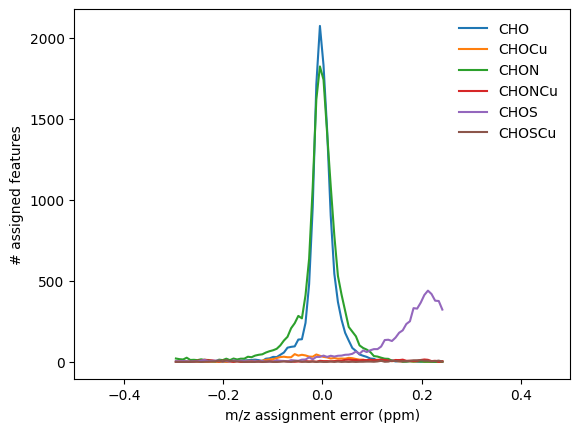

In [37]:
fresults1 = assignMolClass(results1)

pltMZerror(fresults1, bins=75)
plt.show()



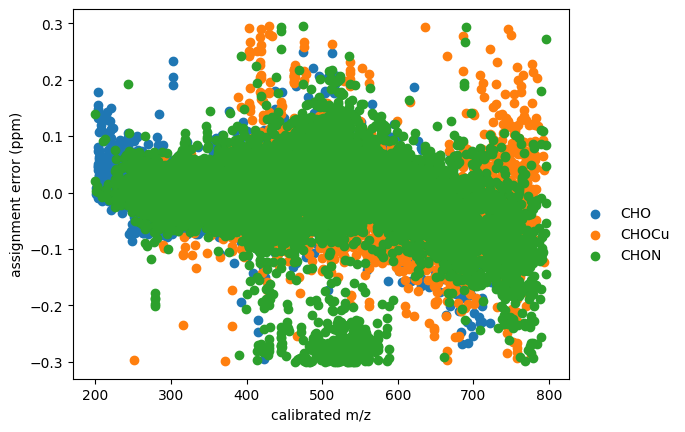

In [11]:
pltMZerror_pts(fresults1)

plt.show()

In [8]:
#trange = [12,14]
#interval = 2
parser2 = getParser(data2)  #400-500mz
results2 = assign_formula(parser2,interval=interval,timerange=trange, refmasslist=refmasslist)



polarity: 1
MS Obj loaded - 1155 peaks found.
MS Obj loaded - 1155 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5084.61 ms


Loading molecular formula database: 199772it [00:05, 35837.64it/s]
Started molecular formula search for class {"N": 3, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 209.66it/s]
Loading molecular formula database: 67135it [00:01, 42076.51it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 339.32it/s]


'run_molecular_formula'  14026.63 ms
540 assigned peaks and 615 unassigned peaks, total  = 46.75 %, relative abundance = 45.15 %, RMS error (best candidate) (ppm) = 0.220
polarity: 1
MS Obj loaded - 1591 peaks found.
MS Obj loaded - 1591 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
2 calibration points matched within thresholds.
'runworker'  5048.14 ms


Loading molecular formula database: 199772it [00:05, 36377.48it/s] 
Started molecular formula search for class {"N": 3, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 156.42it/s]
Loading molecular formula database: 67135it [00:01, 37894.33it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 249.38it/s]


'run_molecular_formula'  14671.76 ms
973 assigned peaks and 618 unassigned peaks, total  = 61.16 %, relative abundance = 62.23 %, RMS error (best candidate) (ppm) = 0.089
polarity: 1
MS Obj loaded - 1981 peaks found.
MS Obj loaded - 1981 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
5 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.030 ppm
minimize function performed 177 fn evals and 2 iterations
'runworker'  4901.55 ms


Loading molecular formula database: 199772it [00:05, 37410.62it/s] 
Started molecular formula search for class {"N": 3, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 125.92it/s]
Loading molecular formula database: 67135it [00:01, 35622.49it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 197.12it/s]


'run_molecular_formula'  15056.92 ms
1255 assigned peaks and 726 unassigned peaks, total  = 63.35 %, relative abundance = 68.51 %, RMS error (best candidate) (ppm) = 0.101
polarity: 1
MS Obj loaded - 2115 peaks found.
MS Obj loaded - 2115 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
58 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.011 ppm
minimize function performed 690 fn evals and 10 iterations
'runworker'  5366.23 ms


Loading molecular formula database: 199772it [00:05, 39739.66it/s] 
Started molecular formula search for class {"N": 3, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 118.06it/s]
Loading molecular formula database: 67135it [00:01, 35619.50it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 190.33it/s]


'run_molecular_formula'  15385.80 ms
1414 assigned peaks and 701 unassigned peaks, total  = 66.86 %, relative abundance = 71.02 %, RMS error (best candidate) (ppm) = 0.058
polarity: 1
MS Obj loaded - 2461 peaks found.
MS Obj loaded - 2461 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
96 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 612 fn evals and 8 iterations
'runworker'  4860.89 ms


Loading molecular formula database: 199772it [00:05, 36790.95it/s] 
Started molecular formula search for class {"N": 3, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 103.06it/s]
Loading molecular formula database: 67135it [00:01, 35787.95it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 163.66it/s]


'run_molecular_formula'  15729.90 ms
1624 assigned peaks and 837 unassigned peaks, total  = 65.99 %, relative abundance = 75.41 %, RMS error (best candidate) (ppm) = 0.061
polarity: 1
MS Obj loaded - 2508 peaks found.
MS Obj loaded - 2508 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
108 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 372 fn evals and 7 iterations
'runworker'  5164.44 ms


Loading molecular formula database: 199772it [00:05, 38012.42it/s] 
Started molecular formula search for class {"N": 3, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 100.84it/s]
Loading molecular formula database: 67135it [00:01, 37506.26it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 163.11it/s]


'run_molecular_formula'  15838.54 ms
1693 assigned peaks and 815 unassigned peaks, total  = 67.50 %, relative abundance = 79.26 %, RMS error (best candidate) (ppm) = 0.058
polarity: 1
MS Obj loaded - 2527 peaks found.
MS Obj loaded - 2527 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
117 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.015 ppm
minimize function performed 371 fn evals and 7 iterations
'runworker'  5083.97 ms


Loading molecular formula database: 199772it [00:05, 39527.10it/s] 
Started molecular formula search for class {"N": 3, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 100.13it/s]
Loading molecular formula database: 67135it [00:01, 33851.63it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 162.01it/s]


'run_molecular_formula'  15774.72 ms
1729 assigned peaks and 798 unassigned peaks, total  = 68.42 %, relative abundance = 81.35 %, RMS error (best candidate) (ppm) = 0.057
polarity: 1
MS Obj loaded - 2598 peaks found.
MS Obj loaded - 2598 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
118 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 374 fn evals and 7 iterations
'runworker'  4815.66 ms


Loading molecular formula database: 199772it [00:05, 36769.89it/s] 
Started molecular formula search for class {"N": 3, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 98.33it/s] 
Loading molecular formula database: 67135it [00:02, 32900.11it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 158.99it/s]


'run_molecular_formula'  16009.57 ms
1818 assigned peaks and 780 unassigned peaks, total  = 69.98 %, relative abundance = 83.82 %, RMS error (best candidate) (ppm) = 0.058
polarity: 1
MS Obj loaded - 2489 peaks found.
MS Obj loaded - 2489 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
119 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.019 ppm
minimize function performed 369 fn evals and 7 iterations
'runworker'  4892.89 ms


Loading molecular formula database: 199772it [00:05, 34812.08it/s] 
Started molecular formula search for class {"N": 3, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 101.88it/s]
Loading molecular formula database: 67135it [00:01, 36281.46it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 161.64it/s]


'run_molecular_formula'  16086.99 ms
1795 assigned peaks and 694 unassigned peaks, total  = 72.12 %, relative abundance = 85.50 %, RMS error (best candidate) (ppm) = 0.057
polarity: 1
MS Obj loaded - 2574 peaks found.
MS Obj loaded - 2574 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
116 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.019 ppm
minimize function performed 376 fn evals and 7 iterations
'runworker'  4868.28 ms


Loading molecular formula database: 199772it [00:05, 35091.39it/s] 
Started molecular formula search for class {"N": 3, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 99.93it/s] 
Loading molecular formula database: 67135it [00:01, 41149.15it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 156.76it/s]


'run_molecular_formula'  15875.12 ms
1899 assigned peaks and 675 unassigned peaks, total  = 73.78 %, relative abundance = 86.02 %, RMS error (best candidate) (ppm) = 0.062
polarity: 1
MS Obj loaded - 1870 peaks found.
MS Obj loaded - 1870 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
97 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.016 ppm
minimize function performed 368 fn evals and 7 iterations
'runworker'  5373.44 ms


Loading molecular formula database: 199772it [00:05, 37878.39it/s] 
Started molecular formula search for class {"N": 3, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 134.39it/s]
Loading molecular formula database: 67135it [00:01, 37490.45it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 213.11it/s]


'run_molecular_formula'  15180.87 ms
1446 assigned peaks and 424 unassigned peaks, total  = 77.33 %, relative abundance = 86.33 %, RMS error (best candidate) (ppm) = 0.051
polarity: 1
MS Obj loaded - 2339 peaks found.
MS Obj loaded - 2339 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
103 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.015 ppm
minimize function performed 373 fn evals and 7 iterations
'runworker'  4950.56 ms


Loading molecular formula database: 199772it [00:05, 35041.75it/s] 
Started molecular formula search for class {"N": 3, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 108.70it/s]
Loading molecular formula database: 67135it [00:01, 41610.99it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 171.14it/s]


'run_molecular_formula'  15650.06 ms
1563 assigned peaks and 776 unassigned peaks, total  = 66.82 %, relative abundance = 78.92 %, RMS error (best candidate) (ppm) = 0.063


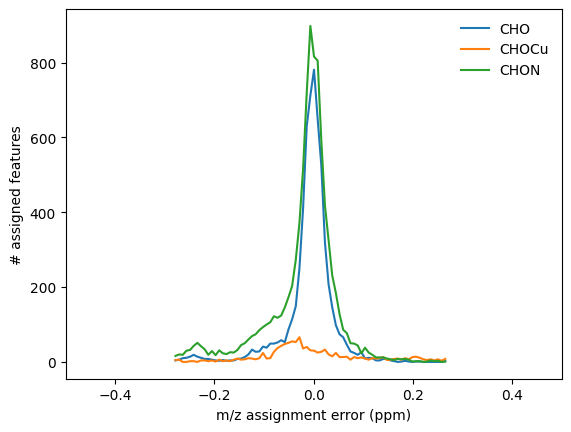

In [12]:
fresults2 = assignMolClass(results2)

pltMZerror(fresults2, bins=75)

plt.show()

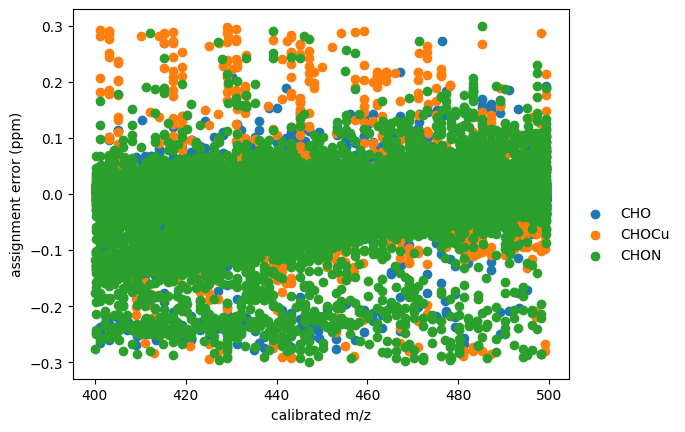

In [13]:
pltMZerror_pts(fresults2)

plt.show()

In [9]:
#trange = [12,14]
#interval = 4

qh2o_parser = getParser(qh2o)
qh2o_results = assign_formula(qh2o_parser,interval=interval,timerange=trange, refmasslist=refmasslist )

polarity: 1
MS Obj loaded - 163 peaks found.
MS Obj loaded - 163 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5432.52 ms


Loading molecular formula database: 199772it [00:05, 39923.57it/s] 
Started molecular formula search for class {"N": 3, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 997.11it/s]
Loading molecular formula database: 67135it [00:01, 39290.80it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 1312.66it/s]


'run_molecular_formula'  12554.72 ms
11 assigned peaks and 152 unassigned peaks, total  = 6.75 %, relative abundance = 0.88 %, RMS error (best candidate) (ppm) = 0.136
polarity: 1
MS Obj loaded - 149 peaks found.
MS Obj loaded - 149 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  4854.75 ms


Loading molecular formula database: 199772it [00:05, 38105.47it/s] 
Started molecular formula search for class {"N": 3, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 1051.24it/s]
Loading molecular formula database: 67135it [00:01, 39841.59it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 1363.72it/s]


'run_molecular_formula'  12174.23 ms
6 assigned peaks and 143 unassigned peaks, total  = 4.03 %, relative abundance = 0.73 %, RMS error (best candidate) (ppm) = 0.144
polarity: 1
MS Obj loaded - 190 peaks found.
MS Obj loaded - 190 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  4997.16 ms


Loading molecular formula database: 199772it [00:05, 36780.80it/s] 
Started molecular formula search for class {"N": 3, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 904.30it/s]
Loading molecular formula database: 67135it [00:01, 42473.14it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 1210.00it/s]


'run_molecular_formula'  12457.82 ms
11 assigned peaks and 179 unassigned peaks, total  = 5.79 %, relative abundance = 0.89 %, RMS error (best candidate) (ppm) = 0.173
polarity: 1
MS Obj loaded - 222 peaks found.
MS Obj loaded - 222 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  4877.94 ms


Loading molecular formula database: 199772it [00:05, 36380.36it/s] 
Started molecular formula search for class {"N": 3, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 829.31it/s]
Loading molecular formula database: 67135it [00:01, 37514.09it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 1123.52it/s]


'run_molecular_formula'  12643.34 ms
13 assigned peaks and 209 unassigned peaks, total  = 5.86 %, relative abundance = 1.29 %, RMS error (best candidate) (ppm) = 0.172
polarity: 1
MS Obj loaded - 268 peaks found.
MS Obj loaded - 268 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  4770.26 ms


Loading molecular formula database: 199772it [00:05, 35618.32it/s] 
Started molecular formula search for class {"N": 3, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 723.62it/s]
Loading molecular formula database: 67135it [00:01, 37291.71it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 905.28it/s]


'run_molecular_formula'  12738.88 ms
16 assigned peaks and 252 unassigned peaks, total  = 5.97 %, relative abundance = 2.05 %, RMS error (best candidate) (ppm) = 0.202
polarity: 1
MS Obj loaded - 400 peaks found.
MS Obj loaded - 400 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5243.41 ms


Loading molecular formula database: 199772it [00:05, 39949.29it/s] 
Started molecular formula search for class {"N": 3, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 542.19it/s]
Loading molecular formula database: 67135it [00:01, 35418.75it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 748.97it/s]


'run_molecular_formula'  12865.13 ms
31 assigned peaks and 369 unassigned peaks, total  = 7.75 %, relative abundance = 2.76 %, RMS error (best candidate) (ppm) = 0.183
polarity: 1
MS Obj loaded - 430 peaks found.
MS Obj loaded - 430 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
4 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.000 ppm
minimize function performed 1206 fn evals and 16 iterations
'runworker'  4932.90 ms


Loading molecular formula database: 199772it [00:05, 35942.89it/s] 
Started molecular formula search for class {"N": 3, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 468.49it/s]
Loading molecular formula database: 67135it [00:01, 37933.00it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 658.31it/s]


'run_molecular_formula'  13092.57 ms
216 assigned peaks and 214 unassigned peaks, total  = 50.23 %, relative abundance = 61.16 %, RMS error (best candidate) (ppm) = 0.127
polarity: 1
MS Obj loaded - 506 peaks found.
MS Obj loaded - 506 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
9 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 589 fn evals and 8 iterations
'runworker'  5369.49 ms


Loading molecular formula database: 199772it [00:05, 39684.03it/s] 
Started molecular formula search for class {"N": 3, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 404.49it/s]
Loading molecular formula database: 67135it [00:01, 38101.42it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 610.05it/s]


'run_molecular_formula'  13110.98 ms
266 assigned peaks and 240 unassigned peaks, total  = 52.57 %, relative abundance = 64.49 %, RMS error (best candidate) (ppm) = 0.126
polarity: 1
MS Obj loaded - 445 peaks found.
MS Obj loaded - 445 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
8 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.007 ppm
minimize function performed 577 fn evals and 8 iterations
'runworker'  5067.11 ms


Loading molecular formula database: 199772it [00:05, 39111.90it/s] 
Started molecular formula search for class {"N": 3, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 446.59it/s]
Loading molecular formula database: 67135it [00:01, 34986.72it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 680.69it/s]


'run_molecular_formula'  12952.53 ms
259 assigned peaks and 186 unassigned peaks, total  = 58.20 %, relative abundance = 66.04 %, RMS error (best candidate) (ppm) = 0.110
polarity: 1
MS Obj loaded - 369 peaks found.
MS Obj loaded - 369 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
6 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.005 ppm
minimize function performed 836 fn evals and 12 iterations
'runworker'  5388.49 ms


Loading molecular formula database: 199772it [00:04, 40411.66it/s] 
Started molecular formula search for class {"N": 3, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 533.01it/s]
Loading molecular formula database: 67135it [00:01, 38051.92it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 796.68it/s]


'run_molecular_formula'  12822.68 ms
197 assigned peaks and 172 unassigned peaks, total  = 53.39 %, relative abundance = 72.64 %, RMS error (best candidate) (ppm) = 0.135
polarity: 1
MS Obj loaded - 216 peaks found.
MS Obj loaded - 216 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
3 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.000 ppm
minimize function performed 332 fn evals and 3 iterations
'runworker'  5374.02 ms


Loading molecular formula database: 199772it [00:05, 39247.25it/s] 
Started molecular formula search for class {"N": 3, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 817.74it/s]
Loading molecular formula database: 67135it [00:01, 38025.88it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 976.95it/s]


'run_molecular_formula'  12735.38 ms
76 assigned peaks and 140 unassigned peaks, total  = 35.19 %, relative abundance = 62.41 %, RMS error (best candidate) (ppm) = 0.202
polarity: 1
MS Obj loaded - 373 peaks found.
MS Obj loaded - 373 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
4 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.006 ppm
minimize function performed 180 fn evals and 2 iterations
'runworker'  4888.16 ms


Loading molecular formula database: 199772it [00:05, 35211.33it/s]
Started molecular formula search for class {"N": 3, "O": 15, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 525.08it/s]
Loading molecular formula database: 67135it [00:01, 41559.32it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1, "Na": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 716.10it/s]


'run_molecular_formula'  12926.37 ms
164 assigned peaks and 209 unassigned peaks, total  = 43.97 %, relative abundance = 35.81 %, RMS error (best candidate) (ppm) = 0.146


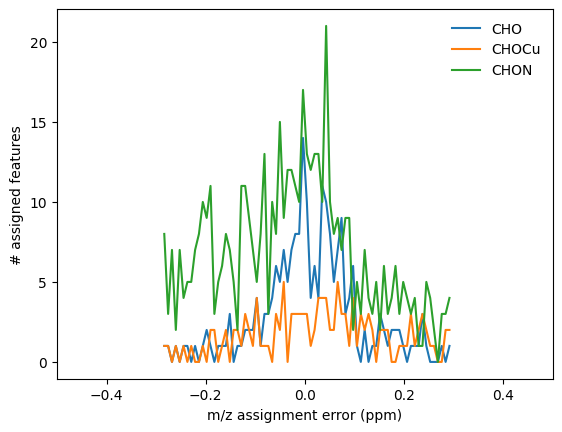

In [14]:
fresults3 = assignMolClass(qh2o_results)

pltMZerror(fresults3, bins=75)

plt.show()

In [15]:

## filter molform 
sub = filterMzRange(results1,[400,500])

blank_subtracted_n = results2[~results2['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

blank_subtracted_full = sub[~sub['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

overlap = blank_subtracted_n[blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

narrow_unique = blank_subtracted_n[~blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

full_range_bs = results1[~results1['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]


22096     29.718683
22101     46.404848
22105     10.721534
22106      6.118698
22107     41.787552
            ...    
23194    152.547575
23197      8.049304
23198      6.555738
23199    174.027108
23201     33.628470
Name: S/N Norm, Length: 1095, dtype: float64


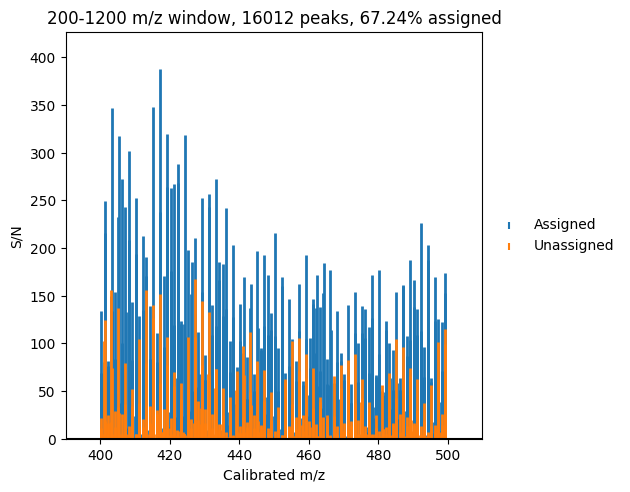

In [16]:


sn_lim = 20
df2=narrow_unique[narrow_unique['S/N']<sn_lim]

df1=blank_subtracted_full[blank_subtracted_full['S/N']<sn_lim]
df2=narrow_unique[narrow_unique['S/N']<sn_lim]
df3=overlap[overlap['S/N']<sn_lim]


df2a = sub[sub['Molecular Formula'].notna()]
df2b = sub[sub['Molecular Formula'].isna()]

n_mzs = np.shape(sub)[0]

per_a = np.shape(df2a)[0]  / (np.shape(df2a)[0] + np.shape(df2b)[0]) *100
per_b = np.shape(df2b)[0]  / (np.shape(df2a)[0] + np.shape(df2b)[0]) *100

plot_ms(df2a,df2=df2b, start_mz=400,end_mz = 500, tstart = 16, lbls=['Assigned', 'Unassigned'],labs=False) 

plt.title('200-1200 m/z window, %s peaks, %.2f%% assigned' %(n_mzs, per_a))
plt.show()






11814     11.215154
11815      4.618664
11816     48.348724
11817     10.117067
11818      2.818922
            ...    
13539      2.181479
13540    122.802990
13541      2.476481
13542      2.004465
13543     26.078222
Name: S/N Norm, Length: 1730, dtype: float64


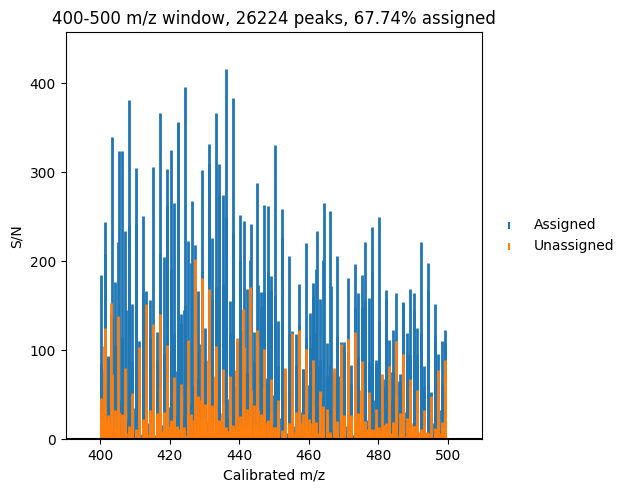

In [17]:


df2a = results2[results2['Molecular Formula'].notna()]
df2b = results2[results2['Molecular Formula'].isna()]

n_mzs = np.shape(results2)[0]

per_a = np.shape(df2a)[0]  / (np.shape(df2a)[0] + np.shape(df2b)[0]) *100
per_b = np.shape(df2b)[0]  / (np.shape(df2a)[0] + np.shape(df2b)[0]) *100

plot_ms(df2a,df2=df2b, start_mz=400,end_mz = 500, tstart = 16, lbls=['Assigned', 'Unassigned' ],labs=False) 

plt.title('400-500 m/z window, %s peaks, %.2f%% assigned' %(n_mzs, per_a))
plt.show()

8449     10.739861
8450      2.255599
8451      3.533641
8452     14.515331
8453     54.823377
           ...    
11043     2.679138
11044     2.127996
11045     9.789416
11046     2.435786
11047     3.315222
Name: S/N Norm, Length: 2599, dtype: float64


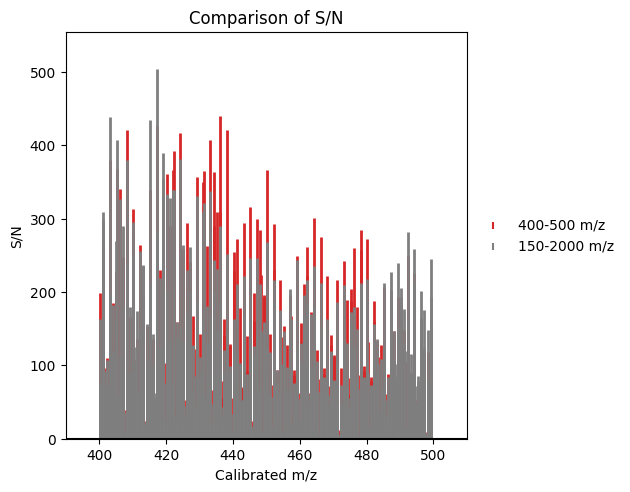

In [214]:

df2a = results2 #[results2['Molecular Formula'].notna()]
df2b = sub #[sub['Molecular Formula'].notna()]

n_mzs = np.shape(results2)[0]

per_a = np.shape(df2a)[0]  / (np.shape(df2a)[0] + np.shape(df2b)[0]) *100
per_b = np.shape(df2b)[0]  / (np.shape(df2a)[0] + np.shape(df2b)[0]) *100

plot_ms(df2a,df2=df2b, start_mz=400,end_mz = 500, tstart = 16, lbls=['400-500 m/z', '150-2000 m/z' ],labs=False, colors=['C3','C7']) 

plt.title('Comparison of S/N')
plt.show()

11814     11.215154
11815      4.618664
11816     48.348724
11818      2.818922
11819     85.644396
            ...    
13538      7.930126
13540    122.802990
13541      2.476481
13542      2.004465
13543     26.078222
Name: S/N Norm, Length: 1275, dtype: float64


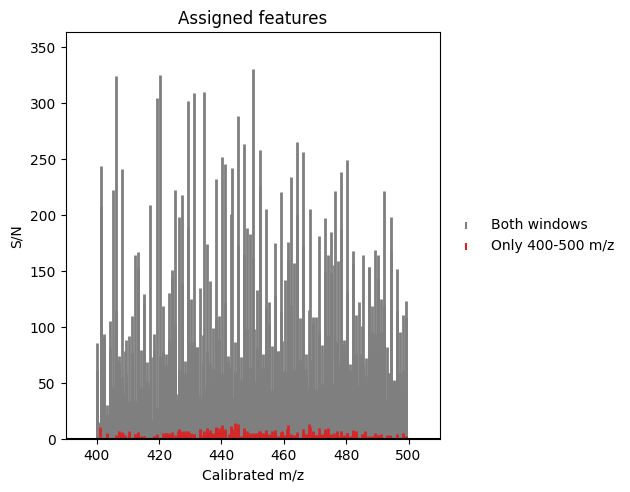

In [18]:
blank_subtracted_n = results2[~results2['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

blank_subtracted_full = sub[~sub['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

overlap = blank_subtracted_n[blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

narrow_unique = blank_subtracted_n[~blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

full_range_bs = results1[~results1['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]



df2a = overlap #[results2['Molecular Formula'].notna()]
df2b = narrow_unique #[sub['Molecular Formula'].notna()]

n_mzs = np.shape(results2)[0]

per_a = np.shape(df2a)[0]  / (np.shape(df2a)[0] + np.shape(df2b)[0]) *100
per_b = np.shape(df2b)[0]  / (np.shape(df2a)[0] + np.shape(df2b)[0]) *100

plot_ms(df2a,df2=df2b, start_mz=400,end_mz = 500, tstart = 16, lbls=['Both windows', 'Only 400-500 m/z' ],labs=False,colors=['C7','C3']) 

plt.title('Assigned features')
plt.show()

12721     38.289563
12724     81.364891
12728     23.476701
12729     10.916603
12731      3.204689
12732     38.116747
12734     25.428832
12736     51.928140
12738     13.575857
12739     37.941268
12741    132.477256
12743     21.651461
12744     30.800705
12748      4.858318
12749      5.540937
Name: S/N Norm, dtype: float64


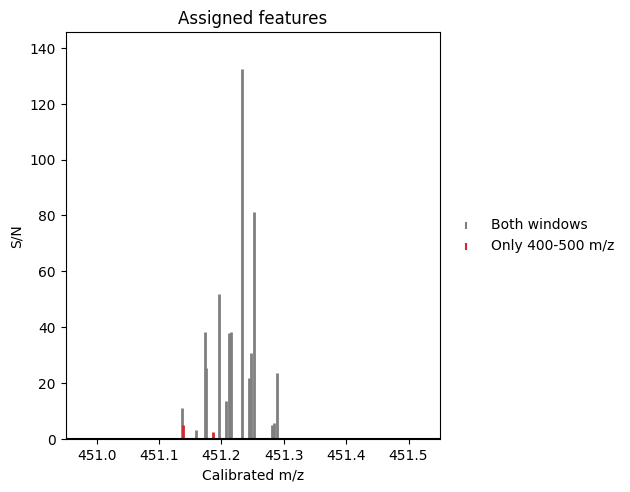

In [19]:
blank_subtracted_n = results2[~results2['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

blank_subtracted_full = sub[~sub['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

overlap = blank_subtracted_n[blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

narrow_unique = blank_subtracted_n[~blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

full_range_bs = results1[~results1['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]



df2a = overlap#[overlap['S'] > 0]
df2b = narrow_unique#[narrow_unique['S'] > 0] #[sub['Molecular Formula'].notna()]



plot_ms(df2a,df2=df2b, start_mz=451,end_mz = 451.5, tstart = 16, lbls=['Both windows', 'Only 400-500 m/z' ],labs=False,colors=['C7','C3']) 

plt.title('Assigned features')
plt.show()

11854     2.395107
11857    11.943740
11883     8.472082
11887    13.495140
11915     2.393822
           ...    
13470    11.509980
13487     6.093011
13499    30.166434
13500     4.974354
13531     7.656687
Name: S/N Norm, Length: 85, dtype: float64


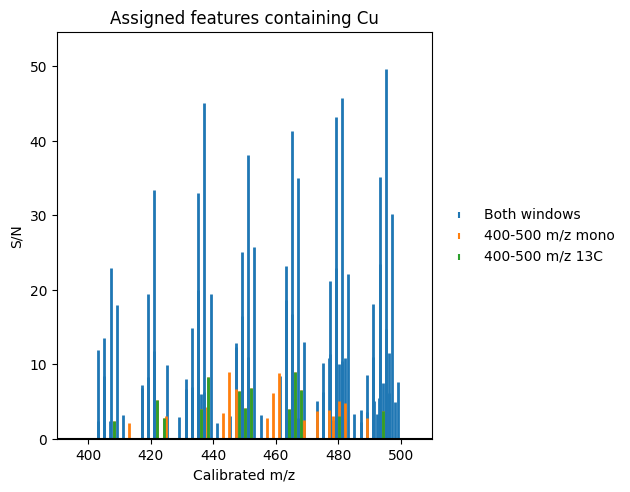

In [20]:
blank_subtracted_n = results2[~results2['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

blank_subtracted_full = sub[~sub['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

overlap = blank_subtracted_n[blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

narrow_unique = blank_subtracted_n[~blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

full_range_bs = results1[~results1['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]



df2a = overlap[overlap['Cu'] > 0]
df2b = narrow_unique[narrow_unique['Cu'] > 0] #[sub['Molecular Formula'].notna()]
df2c = df2b[df2b['13C'] > 0]



plot_ms(df2a,df2=df2b,df3=df2c, start_mz=400,end_mz = 500, tstart = 16, lbls=['Both windows', '400-500 m/z mono', '400-500 m/z 13C' ],labs=False) 

plt.title('Assigned features containing Cu')
plt.show()

ValueError: s must be a scalar, or float array-like with the same size as x and y

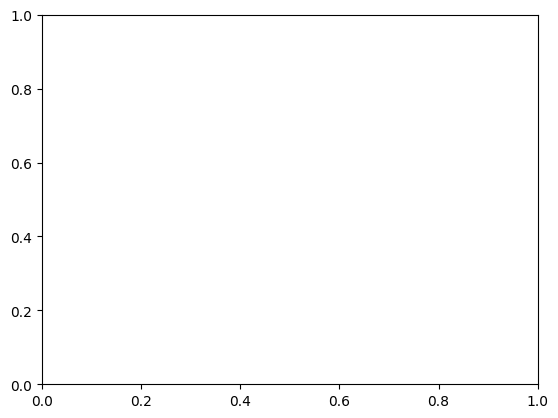

In [218]:
df2a_f = assignMolClass(df2a)

fig, ax = plt.subplots()
ax.scatter(x=df2a_f['N/C'],y=df2a_f['O/C'],s=df2a['Peak Height']/100,c='C3',label='400-500 m/z')
ax.set(xlabel='O/C',ylabel='N/C')
ax.set_xlim(0,1.2)
ax.set_ylim(0,0.5)
#ax.legend(frameon=False)
plt.show()

180     2.696597
370     2.343571
1013    2.502200
1049    2.416135
1134    2.069163
1302    2.006363
1319    2.258869
1387    2.344515
1637    2.341975
1710    2.504763
1728    2.792120
Name: S/N Norm, dtype: float64


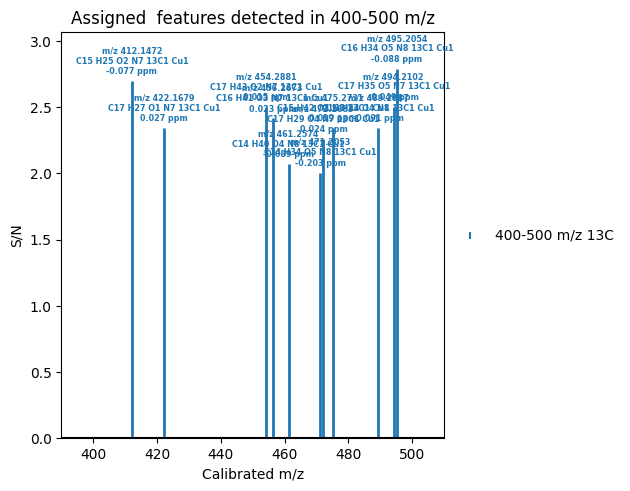

In [185]:


plot_ms(df2c, start_mz=400,end_mz = 500, tstart = 16, lbls=[ '400-500 m/z 13C' ],labs=True) 

plt.title('Assigned  features detected in 400-500 m/z')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


179     23.833342
180      2.696597
369     20.825349
370      2.343571
425      2.846401
463      2.927746
572      4.171864
675      2.027237
853      4.026634
983      4.371135
1012    19.258412
1013     2.502200
1048    19.951509
1049     2.416135
1108     2.914003
1133    18.703138
1134     2.069163
1140     2.745964
1301    17.574180
1302     2.006363
1318    19.413562
1319     2.258869
1323     2.984644
1359     2.435351
1386    21.612367
1387     2.344515
1425     4.199668
1531     2.017922
1536     2.962540
1611     2.435297
1636    21.070407
1637     2.341975
1709    20.797747
1710     2.504763
1727    21.584907
1728     2.792120
Name: S/N Norm, dtype: float64
1642    4.038326
1792    3.194318
Name: S/N Norm, dtype: float64


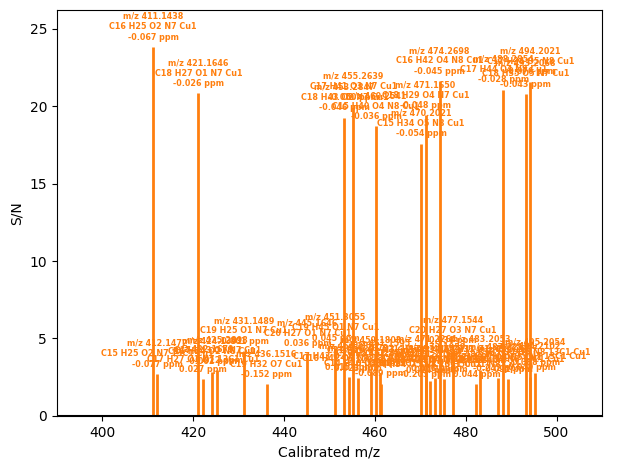

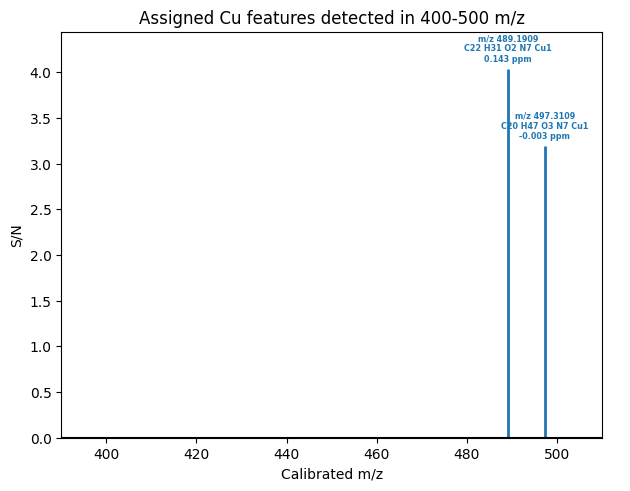

In [182]:
blank_subtracted_n = results2[~results2['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

blank_subtracted_full = sub[~sub['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

overlap = blank_subtracted_n[blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

narrow_unique = blank_subtracted_n[~blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

full_range_bs = results1[~results1['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]



df2b = narrow_unique[narrow_unique['Cu'] > 0] #[sub['Molecular Formula'].notna()]
df2a = overlap[overlap['Cu'] > 0] #[sub['Molecular Formula'].notna()]


plot_ms(df2b, start_mz=400,end_mz = 500, tstart = 16, lbls=[ '' ],labs=True,colors=['C1']) 

plot_ms(df2a, start_mz=400,end_mz = 500, tstart = 16, lbls=[ '' ],labs=True,colors=['C0']) 


plt.title('Assigned Cu features detected in 400-500 m/z')
plt.show()

(198, 28)
358    8.600747
373    7.841299
376    4.841465
378    4.880732
Name: S/N Norm, dtype: float64


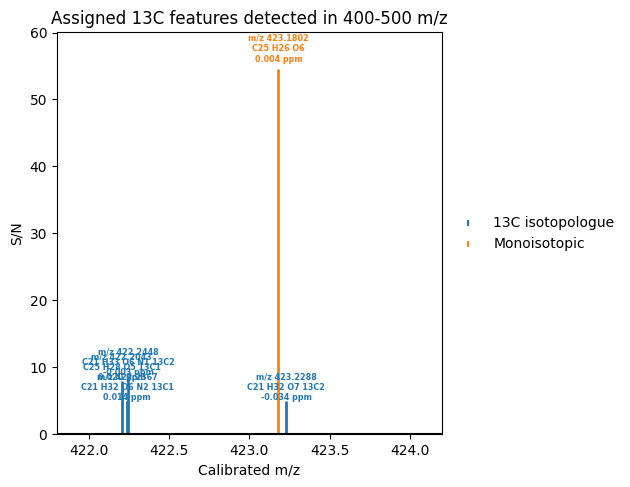

In [18]:
blank_subtracted_n = results2[~results2['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

blank_subtracted_full = sub[~sub['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

overlap = blank_subtracted_n[blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

narrow_unique = blank_subtracted_n[~blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

full_range_bs = results1[~results1['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]



df2a = narrow_unique[narrow_unique['Cu'] > 0] #[sub['Molecular Formula'].notna()]

df2b = blank_subtracted_n.loc[blank_subtracted_n['Index'].isin(df2a['Mono Isotopic Index'] )]
print(np.shape(df2b))

plot_ms(df2a, df2=df2b,start_mz=422,end_mz = 424, tstart = 16, lbls=[ '13C isotopologue', 'Monoisotopic' ],labs=True) 

plt.title('Assigned 13C features detected in 400-500 m/z')
plt.show()

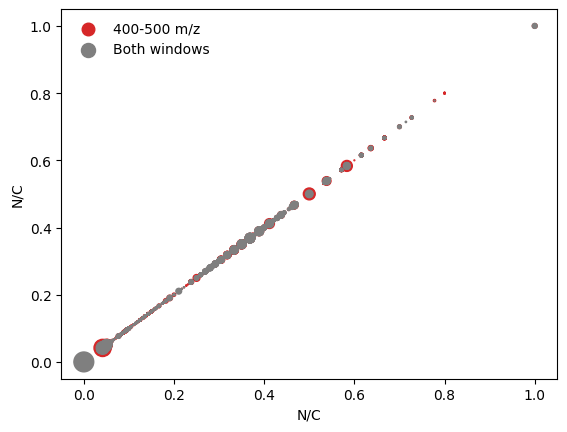

In [219]:
## van Krevelen plots 
## N/C, H/C
sub = filterMzRange(fresults1,[400,500])
fig, ax = plt.subplots()
ax.scatter(x=fresults2['N/C'],y=fresults2['N/C'],s=fresults2['Peak Height']/4000,c='C3',label='400-500 m/z')
ax.scatter(x=sub['N/C'],y=sub['N/C'],s=sub['Peak Height']/4000,c='C7',label='Both windows')
ax.set(xlabel='N/C',ylabel='N/C')
ax.legend(frameon=False)
plt.show()

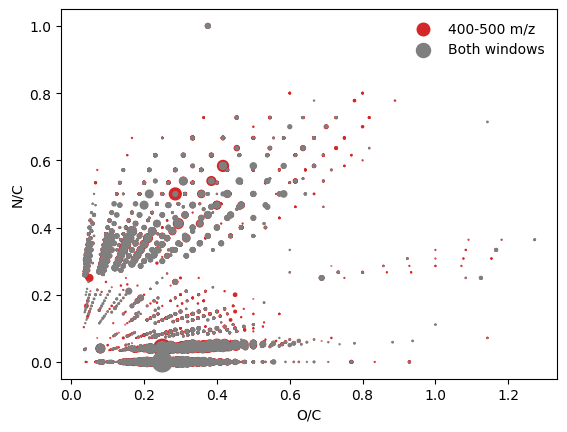

In [221]:

## O/C, N/C

sub = filterMzRange(fresults1,[400,500])
fig, ax = plt.subplots()
ax.scatter(x=fresults2['O/C'],y=fresults2['N/C'],s=fresults2['Peak Height']/4000,c='C3',label='400-500 m/z')
ax.scatter(x=sub['O/C'],y=sub['N/C'],s=sub['Peak Height']/4000,c='C7',label='Both windows')
ax.set(xlabel='O/C',ylabel='N/C')
ax.legend(frameon=False)
plt.show()

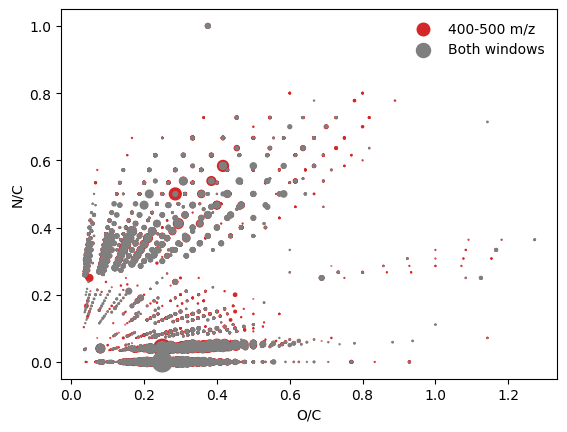

In [222]:
## van Krevelen plots 
## O/C, N/C
sub = filterMzRange(fresults1,[400,500])
fig, ax = plt.subplots()
ax.scatter(x=fresults2['O/C'],y=fresults2['N/C'],s=fresults2['Peak Height']/4000,c='C3',label='400-500 m/z')
ax.scatter(x=sub['O/C'],y=sub['N/C'],s=sub['Peak Height']/4000,c='C7',label='Both windows')
ax.set(xlabel='O/C',ylabel='N/C')
ax.legend(frameon=False)
plt.show()